In [292]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
import sklearn.gaussian_process as gp
from sklearn import preprocessing
import shap
import pickle

In [229]:
#data to be used for retention estimation including a number of variables
data = pd.read_excel('../results/Variables to consider.xlsx')
data.head()

,Link to trial,Number of Participants,Retention rate,Study Duration - weeks,Age range (18-65) %,Age range >65 %,Male %,White ethnicity %,Other ethnicity %,medication,...,"income level (low, median,high)",treatment type,"biosample collection (e.g. blood, tissue)",is randomised,insurance,mutli-site,Adverse event considered,support sessions,self-management,Unnamed: 29
0,https://classic.clinicaltrials.gov/ct2/show/re...,71,83.1,14,18.3,81.7,50.7,93.0,7.0,Escitalopram,...,NaN,medication,no,no,NaN,no,no,no,no,NaN
1,https://classic.clinicaltrials.gov/ct2/show/re...,106,84.9,14,23.3,76.7,43.3,83.3,16.7,Escitalopram,...,NaN,medication,no,no,NaN,no,yes,no,no,NaN
2,https://classic.clinicaltrials.gov/ct2/show/re...,9,100.0,8,100.0,0.0,0.0,NaN,NaN,Testosterone,...,NaN,medication,no,no,NaN,no,no,no,no,NaN
3,https://classic.clinicaltrials.gov/ct2/show/re...,30,90.0,8,0.0,100.0,23.2,NaN,NaN,NaN,...,NaN,behavioural,no,no,NaN,no,no,yes,no,NaN
4,https://classic.clinicaltrials.gov/ct2/show/re...,17,76.5,12,100.0,0.0,76.5,100.0,0.0,NaN,...,NaN,behavioural,no,yes,NaN,no,yes,no,no,NaN


In [230]:
data.drop('insurance', inplace = True,axis=1) # no data for this currently
data.drop('Unnamed: 29', inplace = True,axis=1)
data.drop('Link to trial', inplace = True,axis=1)#trial id
data.drop('income level (low, median,high)', inplace = True,axis=1)# no data for this currently
data.head()

,Number of Participants,Retention rate,Study Duration - weeks,Age range (18-65) %,Age range >65 %,Male %,White ethnicity %,Other ethnicity %,medication,Follow up considered,...,Use of technology to support,prioir treatment history considered,co-mobidities considered,treatment type,"biosample collection (e.g. blood, tissue)",is randomised,mutli-site,Adverse event considered,support sessions,self-management
0,71,83.1,14,18.3,81.7,50.7,93.0,7.0,Escitalopram,no,...,no,no,no,medication,no,no,no,no,no,no
1,106,84.9,14,23.3,76.7,43.3,83.3,16.7,Escitalopram,no,...,no,no,no,medication,no,no,no,yes,no,no
2,9,100.0,8,100.0,0.0,0.0,NaN,NaN,Testosterone,no,...,no,no,no,medication,no,no,no,no,no,no
3,30,90.0,8,0.0,100.0,23.2,NaN,NaN,NaN,no,...,no,no,no,behavioural,no,no,no,no,yes,no
4,17,76.5,12,100.0,0.0,76.5,100.0,0.0,NaN,yes,...,yes,no,no,behavioural,no,yes,no,yes,no,no


In [231]:
#simple imputations used to be updated when there is a large dataset extracted
data_imp = data.copy()
data_imp['medication'] = data_imp['medication'].fillna('not specified')
data_imp['White ethnicity %'] = data_imp['White ethnicity %'].fillna(data_imp['White ethnicity %'].mean())
data_imp['Other ethnicity %'] = data_imp['Other ethnicity %'].fillna(data_imp['Other ethnicity %'].mean())
data_imp.head()

,Number of Participants,Retention rate,Study Duration - weeks,Age range (18-65) %,Age range >65 %,Male %,White ethnicity %,Other ethnicity %,medication,Follow up considered,...,Use of technology to support,prioir treatment history considered,co-mobidities considered,treatment type,"biosample collection (e.g. blood, tissue)",is randomised,mutli-site,Adverse event considered,support sessions,self-management
0,71,83.1,14,18.3,81.7,50.7,93.000000,7.000000,Escitalopram,no,...,no,no,no,medication,no,no,no,no,no,no
1,106,84.9,14,23.3,76.7,43.3,83.300000,16.700000,Escitalopram,no,...,no,no,no,medication,no,no,no,yes,no,no
2,9,100.0,8,100.0,0.0,0.0,74.321053,25.626316,Testosterone,no,...,no,no,no,medication,no,no,no,no,no,no
3,30,90.0,8,0.0,100.0,23.2,74.321053,25.626316,not specified,no,...,no,no,no,behavioural,no,no,no,no,yes,no
4,17,76.5,12,100.0,0.0,76.5,100.000000,0.000000,not specified,yes,...,yes,no,no,behavioural,no,yes,no,yes,no,no


In [232]:
binary_columns = ['Follow up considered',
       'Use of wearables', 'Use of mobile app', 'Training sessions',
       'Interviews needed', 'Questionare completed',
       'Feedback to users provided ', 'Use of technology to support',
       'prioir treatment history considered', 'co-mobidities considered',
       'biosample collection (e.g. blood, tissue)',
       'is randomised', 'mutli-site', 'Adverse event considered',
       'support sessions', 'self-management']

for c in binary_columns:
    data_imp.loc[data_imp[c] == 'yes',c] = 1
    data_imp.loc[data_imp[c] == 'no',c] = 0
    
m = pd.get_dummies(data_imp['medication'], prefix='medication')
t = pd.get_dummies(data_imp['treatment type'], prefix='treatment type')

data_imp.drop('medication', inplace = True,axis=1) # no data for this currently
data_imp.drop('treatment type', inplace = True,axis=1)

data_imp = pd.concat([data_imp, m, t], axis=1)
data_imp.head()

,Number of Participants,Retention rate,Study Duration - weeks,Age range (18-65) %,Age range >65 %,Male %,White ethnicity %,Other ethnicity %,Follow up considered,Use of wearables,...,medication_Antidepressant medication,medication_Escitalopram,medication_Testosterone,medication_citalopram,medication_not specified,medication_venlafaxine,treatment type_behavioural,treatment type_medication,treatment type_observational,treatment type_rTMS
0,71,83.1,14,18.3,81.7,50.7,93.000000,7.000000,0,0,...,0,1,0,0,0,0,0,1,0,0
1,106,84.9,14,23.3,76.7,43.3,83.300000,16.700000,0,0,...,0,1,0,0,0,0,0,1,0,0
2,9,100.0,8,100.0,0.0,0.0,74.321053,25.626316,0,0,...,0,0,1,0,0,0,0,1,0,0
3,30,90.0,8,0.0,100.0,23.2,74.321053,25.626316,0,0,...,0,0,0,0,1,0,1,0,0,0
4,17,76.5,12,100.0,0.0,76.5,100.000000,0.000000,1,0,...,0,0,0,0,1,0,1,0,0,0


In [286]:
X = data_imp.copy()
X.drop('Retention rate', inplace = True,axis=1)
y = data_imp['Retention rate']

#train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Learn retention based on available data

In [342]:
#no parameter optimisation is done as the data is just for shwoing the process
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e2)) * gp.kernels.RBF(10.0, (1e-3, 1e2))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [344]:
model.fit(X_train, y_train)
pickle.dump(model, open('model1', 'wb'))
y_pred, std = model.predict(X_test, return_std=True)
y_pred [y_pred>100] = 100
mse = ((y_pred-y_test)**2).mean()
y_pred #we need to make sure variables are within range 

array([100.        ,  99.73115839,  83.84088756,  95.05990877])

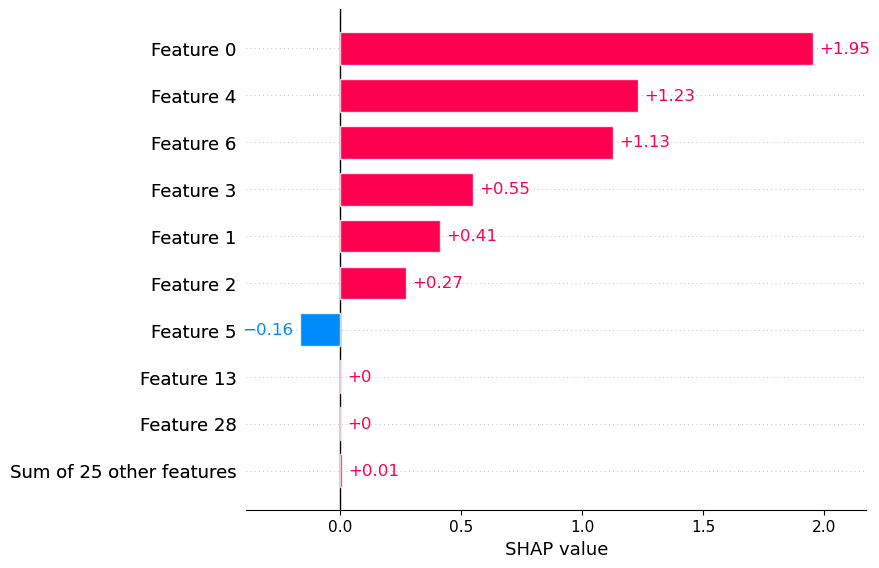

In [347]:
#feature improtance using shap
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.plots.bar(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


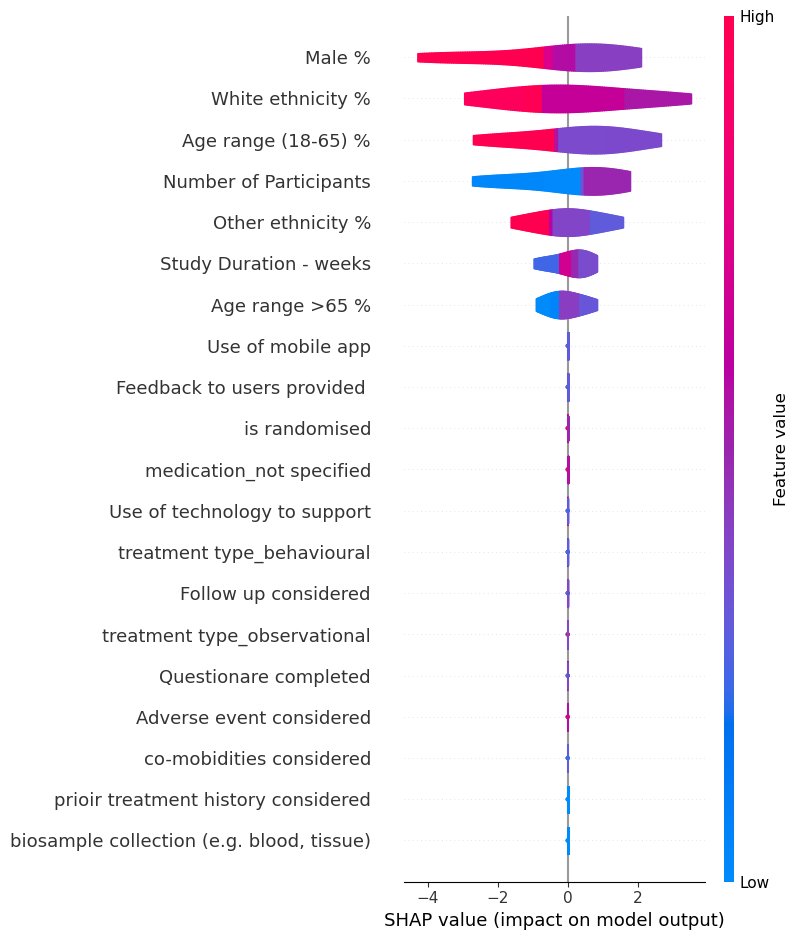

In [346]:
shap.summary_plot(shap_values, plot_type='violin',feature_names = X.columns)